<a href="https://colab.research.google.com/github/GenaroHacker/creating_chord_collection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#@title Set Up
!git clone https://github.com/GenaroHacker/write_imports.git
from write_imports.write_imports import write_imports

!git clone https://github.com/GenaroHacker/creating_chord_collection.git


from creating_chord_collection.collection.resources.scales import scales
from creating_chord_collection.collection.resources.transposable_figures import transposable_figures



In [2]:



# Delete this line to see the new imports
%%capture



#@title Import Statements
#Modules: ['creating_chord_collection', 'write_imports']




from creating_chord_collection.builder.director import Director

from creating_chord_collection.builder.builders import AbstractBuilder
from creating_chord_collection.builder.builders import ShortBuilder
from creating_chord_collection.builder.builders import LongBuilder

from creating_chord_collection.collection.chord import GuitarChord

from creating_chord_collection.collection.collection import ChordCollection



from write_imports.write_imports import write_imports

from write_imports.LearningPython.BasicExamples.intro_functions import print_hello_world





print(write_imports([]))






In [3]:
# @title Chord


# Example
chord = GuitarChord('E', 'm', transposable_figures, finger_ascending=[0, 0, 0, 2, 2, 0], starting_fret=1)
print(chord)
print("String Frequencies:", chord.calculate_frequencies())
print("Is Open Chord:", chord.is_open())
chord.transpose(0)
print(chord.get_notes(include_strings=True))
print(chord.get_notes())

# Validate the chord against the C major scale
ionian_scale = scales["ionian"]
tonic = "C"
is_chord_in_scale = chord.validate_against_scale(tonic, ionian_scale)
print(f"Chord fits in C major scale: {is_chord_in_scale}")


('E', 'm', finger_ascending=[0, 0, 0, 2, 2, 0], starting_fret=1)
String Frequencies: {1: 329.63, 2: 246.94, 3: 196.0, 4: 164.81110255326524, 5: 123.47082531403103, 6: 82.41}
Is Open Chord: True
{1: 'E', 2: 'B', 3: 'G', 4: 'E', 5: 'B', 6: 'E'}
['E', 'B', 'G']
Chord fits in C major scale: True


In [4]:
# @title Scale
from creating_chord_collection.collection.resources.scales import scales

print(scales["ionian"])

[0, 2, 4, 5, 7, 9, 11]


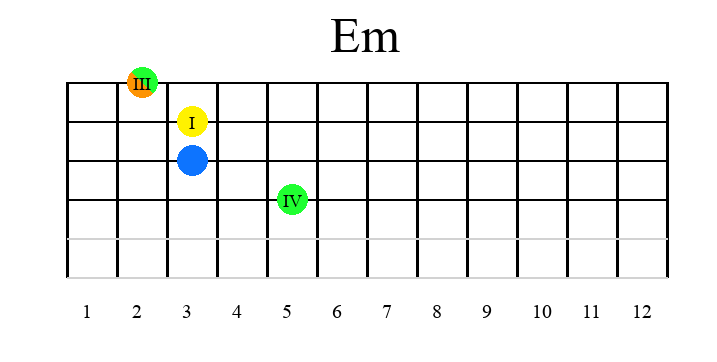

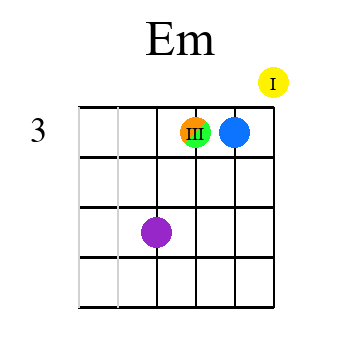

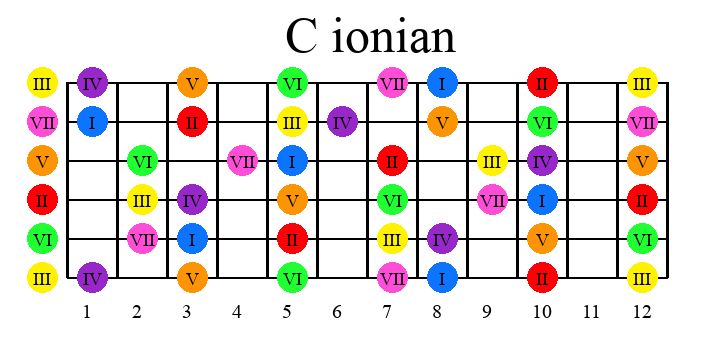

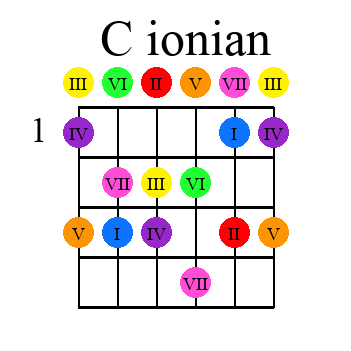

In [12]:
# @title Execution
# Example usage for a chord
chord = GuitarChord('E', 'm', transposable_figures, finger_ascending=[0, 1, 1, 3, None, None], starting_fret=3)
builder = LongBuilder()
director = Director(builder)
director.build_chord(chord)

# Get the final image result and display it
result_image = builder.get_result()
display(result_image)

# Repeat the process with ShortChordBuilder
builder = ShortBuilder()
director = Director(builder)
director.build_chord(chord)

# Get the final image result and display it
result_image = builder.get_result()
display(result_image)

# Define the scale as a list of integers
ionian_scale = [0, 2, 4, 5, 7, 9, 11]
root_note = "C"

# Example usage for a scale with LongScaleBuilder
builder = LongBuilder()
director = Director(builder)
director.build_scale(root_note, ionian_scale)

# Get the final image result and display it
result_image = builder.get_result()
display(result_image)

# Repeat the process with ShortScaleBuilder
builder = ShortBuilder()
director = Director(builder)
director.build_scale(root_note, ionian_scale)

# Get the final image result and display it
result_image = builder.get_result()
display(result_image)
